In [1]:
# import warnings
# warnings.filterwarnings("ignore")

In [2]:
!pip install yfinance

In [3]:
!pip install pandas_market_calendars

In [4]:
!pip install scikeras

In [5]:
!pip install --upgrade fastapi pydantic

In [64]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as datetime
import pandas_market_calendars as pmcal
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from scikeras.wrappers import KerasRegressor
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [7]:
# ticker = input("Enter the strock symbol:")
stock_ticker = yf.Ticker("SBUX")
start_date = datetime.date(2018,1,1)
end_date = datetime.date.today()
data = stock_ticker.history(start = start_date, end = end_date)
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-02 00:00:00-05:00,50.270356,50.495899,49.862640,49.992764,7216000,0.0,0.0
2018-01-03 00:00:00-05:00,50.252995,51.146496,50.140222,50.929626,7478400,0.0,0.0
2018-01-04 00:00:00-05:00,51.172526,51.536865,50.946980,51.120476,5775900,0.0,0.0
2018-01-05 00:00:00-05:00,51.398069,51.779758,51.241923,51.710361,6047700,0.0,0.0
2018-01-08 00:00:00-05:00,51.597593,51.762412,50.799514,51.450123,6335800,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-08 00:00:00-05:00,96.110001,97.639999,96.029999,97.550003,6118700,0.0,0.0
2024-11-11 00:00:00-05:00,98.000000,101.410004,97.949997,100.309998,10313300,0.0,0.0
2024-11-12 00:00:00-05:00,100.129997,100.540001,98.419998,98.800003,8438400,0.0,0.0


In [8]:
data.index = data.index.date

In [9]:
data = data.reset_index(drop = False)
data.rename(columns={'index': 'Dates'}, inplace=True)  # Optional: rename column to "row_index"
type(pd.to_datetime(data["Dates"]))
data

,Dates,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-01-02,50.270356,50.495899,49.862640,49.992764,7216000,0.0,0.0
1,2018-01-03,50.252995,51.146496,50.140222,50.929626,7478400,0.0,0.0
2,2018-01-04,51.172526,51.536865,50.946980,51.120476,5775900,0.0,0.0
3,2018-01-05,51.398069,51.779758,51.241923,51.710361,6047700,0.0,0.0
4,2018-01-08,51.597593,51.762412,50.799514,51.450123,6335800,0.0,0.0
...,...,...,...,...,...,...,...,...
1725,2024-11-08,96.110001,97.639999,96.029999,97.550003,6118700,0.0,0.0
1726,2024-11-11,98.000000,101.410004,97.949997,100.309998,10313300,0.0,0.0
1727,2024-11-12,100.129997,100.540001,98.419998,98.800003,8438400,0.0,0.0
1728,2024-11-13,97.349998,99.940002,96.230003,99.800003,8816300,0.0,0.0


In [10]:
data["Dates"] = pd.to_datetime(data["Dates"])
data.set_index(data["Dates"], inplace = True)  # Set the copied column as the index
data

,Dates,Open,High,Low,Close,Volume,Dividends,Stock Splits
Dates,,,,,,,,
2018-01-02,2018-01-02,50.270356,50.495899,49.862640,49.992764,7216000,0.0,0.0
2018-01-03,2018-01-03,50.252995,51.146496,50.140222,50.929626,7478400,0.0,0.0
2018-01-04,2018-01-04,51.172526,51.536865,50.946980,51.120476,5775900,0.0,0.0
2018-01-05,2018-01-05,51.398069,51.779758,51.241923,51.710361,6047700,0.0,0.0
2018-01-08,2018-01-08,51.597593,51.762412,50.799514,51.450123,6335800,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-11-08,2024-11-08,96.110001,97.639999,96.029999,97.550003,6118700,0.0,0.0
2024-11-11,2024-11-11,98.000000,101.410004,97.949997,100.309998,10313300,0.0,0.0
2024-11-12,2024-11-12,100.129997,100.540001,98.419998,98.800003,8438400,0.0,0.0


In [11]:
data.head()

,Dates,Open,High,Low,Close,Volume,Dividends,Stock Splits
Dates,,,,,,,,
2018-01-02,2018-01-02,50.270356,50.495899,49.862640,49.992764,7216000,0.0,0.0
2018-01-03,2018-01-03,50.252995,51.146496,50.140222,50.929626,7478400,0.0,0.0
2018-01-04,2018-01-04,51.172526,51.536865,50.946980,51.120476,5775900,0.0,0.0
2018-01-05,2018-01-05,51.398069,51.779758,51.241923,51.710361,6047700,0.0,0.0
2018-01-08,2018-01-08,51.597593,51.762412,50.799514,51.450123,6335800,0.0,0.0


#Task - 1

In [12]:
data["Close"]

,Close
Dates,
2018-01-02,49.992764
2018-01-03,50.929626
2018-01-04,51.120476
2018-01-05,51.710361
2018-01-08,51.450123
...,...
2024-11-08,97.550003
2024-11-11,100.309998
2024-11-12,98.800003


In [13]:
scaler = MinMaxScaler(feature_range = (0,1))
data["Scaled_close"] = scaler.fit_transform(pd.DataFrame(data["Close"]))
data

,Dates,Open,High,Low,Close,Volume,Dividends,Stock Splits,Scaled_close
Dates,,,,,,,,,
2018-01-02,2018-01-02,50.270356,50.495899,49.862640,49.992764,7216000,0.0,0.0,0.099481
2018-01-03,2018-01-03,50.252995,51.146496,50.140222,50.929626,7478400,0.0,0.0,0.112015
2018-01-04,2018-01-04,51.172526,51.536865,50.946980,51.120476,5775900,0.0,0.0,0.114568
2018-01-05,2018-01-05,51.398069,51.779758,51.241923,51.710361,6047700,0.0,0.0,0.122460
2018-01-08,2018-01-08,51.597593,51.762412,50.799514,51.450123,6335800,0.0,0.0,0.118979
...,...,...,...,...,...,...,...,...,...
2024-11-08,2024-11-08,96.110001,97.639999,96.029999,97.550003,6118700,0.0,0.0,0.735746
2024-11-11,2024-11-11,98.000000,101.410004,97.949997,100.309998,10313300,0.0,0.0,0.772672
2024-11-12,2024-11-12,100.129997,100.540001,98.419998,98.800003,8438400,0.0,0.0,0.752470


In [14]:
train_start_date = datetime.date(2018, 1, 1)
train_end_date = datetime.date(2022, 12, 31)
print(type(train_start_date))

main_train_data = data.loc[train_start_date:train_end_date]
print(main_train_data.shape)
main_train_data

<class 'datetime.date'>
(1259, 9)


,Dates,Open,High,Low,Close,Volume,Dividends,Stock Splits,Scaled_close
Dates,,,,,,,,,
2018-01-02,2018-01-02,50.270356,50.495899,49.862640,49.992764,7216000,0.0,0.0,0.099481
2018-01-03,2018-01-03,50.252995,51.146496,50.140222,50.929626,7478400,0.0,0.0,0.112015
2018-01-04,2018-01-04,51.172526,51.536865,50.946980,51.120476,5775900,0.0,0.0,0.114568
2018-01-05,2018-01-05,51.398069,51.779758,51.241923,51.710361,6047700,0.0,0.0,0.122460
2018-01-08,2018-01-08,51.597593,51.762412,50.799514,51.450123,6335800,0.0,0.0,0.118979
...,...,...,...,...,...,...,...,...,...
2022-12-23,2022-12-23,93.730991,94.412922,93.049067,94.384102,3944500,0.0,0.0,0.693390
2022-12-27,2022-12-27,94.672243,95.527049,94.326478,95.277328,4402500,0.0,0.0,0.705340
2022-12-28,2022-12-28,95.479040,95.959269,94.499370,94.701065,3491500,0.0,0.0,0.697631


In [15]:
test_start_date = datetime.date(2023, 1, 1)
test_end_date = datetime.date(2023, 12, 31)

main_test_data = data.loc[test_start_date:test_end_date]
print(main_test_data.shape)
main_test_data

(250, 9)


,Dates,Open,High,Low,Close,Volume,Dividends,Stock Splits,Scaled_close
Dates,,,,,,,,,
2023-01-03,2023-01-03,96.583560,97.169440,95.536666,96.842888,6607700,0.0,0.0,0.726286
2023-01-04,2023-01-04,98.629332,100.588666,98.494869,100.329338,8166600,0.0,0.0,0.772931
2023-01-05,2023-01-05,100.358147,100.944026,99.397690,100.300522,5575100,0.0,0.0,0.772545
2023-01-06,2023-01-06,101.212965,102.768908,100.857600,102.471169,9644100,0.0,0.0,0.801586
2023-01-09,2023-01-09,102.307879,102.461556,100.300527,100.598267,10124800,0.0,0.0,0.776529
...,...,...,...,...,...,...,...,...,...
2023-12-22,2023-12-22,93.049906,93.971680,92.510568,93.432343,6360400,0.0,0.0,0.680656
2023-12-26,2023-12-26,93.491171,93.834390,93.118543,93.814774,3709500,0.0,0.0,0.685773
2023-12-27,2023-12-27,93.834391,93.922642,92.951842,93.442146,4959300,0.0,0.0,0.680788


In [16]:
nse = pmcal.get_calendar('NSE')

forecast_start_date = datetime.date(2024, 1, 1)
forecast_end_date = datetime.date(2024, 12, 31)
forecast_dates = nse.schedule(start_date= forecast_start_date, end_date = forecast_end_date)
print(forecast_dates)
forecast_dates = forecast_dates.index
forecast_dates

                         market_open              market_close
2024-01-01 2024-01-01 03:45:00+00:00 2024-01-01 10:00:00+00:00
2024-01-02 2024-01-02 03:45:00+00:00 2024-01-02 10:00:00+00:00
2024-01-03 2024-01-03 03:45:00+00:00 2024-01-03 10:00:00+00:00
2024-01-04 2024-01-04 03:45:00+00:00 2024-01-04 10:00:00+00:00
2024-01-05 2024-01-05 03:45:00+00:00 2024-01-05 10:00:00+00:00
...                              ...                       ...
2024-12-24 2024-12-24 03:45:00+00:00 2024-12-24 10:00:00+00:00
2024-12-26 2024-12-26 03:45:00+00:00 2024-12-26 10:00:00+00:00
2024-12-27 2024-12-27 03:45:00+00:00 2024-12-27 10:00:00+00:00
2024-12-30 2024-12-30 03:45:00+00:00 2024-12-30 10:00:00+00:00
2024-12-31 2024-12-31 03:45:00+00:00 2024-12-31 10:00:00+00:00

[248 rows x 2 columns]


DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-08', '2024-01-09', '2024-01-10',
               '2024-01-11', '2024-01-12',
               ...
               '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20',
               '2024-12-23', '2024-12-24', '2024-12-26', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', length=248, freq=None)

#Task - 2

In [17]:
eval = {}
def evaluate_models(model, name, X_train, y_train, X_test, y_test):
  if(name not in eval.keys()):
    eval[name] = {}
    eval[name]["Mean Absolute Error"] ={}
    eval[name]["Mean Absolute Error"]["train data"] = 0
    eval[name]["Mean Absolute Error"]["test data"] = 0
    eval[name]["Root Mean Squared Error"] ={}
    eval[name]["Root Mean Squared Error"]["train data"] = 0
    eval[name]["Root Mean Squared Error"]["test data"] = 0
    eval[name]["R-Squared Score"] ={}
    eval[name]["R-Squared Score"]["train data"] = 0
    eval[name]["R-Squared Score"]["test data"] = 0

  print("="*25, name, "="*25)
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)

  if(name == "Hybrid Model"):
    train_pred = train_pred[:, -1, 0]
    test_pred = test_pred[:, -1, 0]

  print(train_pred.shape, y_train.shape, X_train.shape)
  print(test_pred.shape, y_test.shape, X_test.shape)

  y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
  train_pred = scaler.inverse_transform(train_pred.reshape(-1, 1))
  y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
  test_pred = scaler.inverse_transform(test_pred.reshape(-1, 1))

  #Mean Absolute Error
  train_mae = mean_absolute_error(train_pred, y_train)
  test_mae = mean_absolute_error(test_pred, y_test)
  print("Mean Absolute Errors is :\n \t\t trained data: ",train_mae,"\n \t\t test data: ", test_mae)
  eval[name]["Mean Absolute Error"]["train data"] = train_mae
  eval[name]["Mean Absolute Error"]["test data"] = test_mae
  print("-"*50)

  #Root Mean Square Error
  train_rmse = root_mean_squared_error(train_pred, y_train)
  test_rmse = root_mean_squared_error(test_pred, y_test)
  print("Root Mean squared Error is :\n \t\t trained data: ",train_rmse,"\n \t\t test data: ", test_rmse)
  eval[name]["Root Mean Squared Error"]["train data"] = train_rmse
  eval[name]["Root Mean Squared Error"]["test data"] = test_rmse
  print("-"*50)

  #R-Squared Error
  train_rs = r2_score(train_pred, y_train)
  test_rs = r2_score(test_pred, y_test)
  print("R-Squared score is :\n \t\t trained data: ",train_rs,"\n \t\t test data: ", test_rs)
  eval[name]["R-Squared Score"]["train data"] = train_rs
  eval[name]["R-Squared Score"]["test data"] = test_rs

  # plotting(model, name, X_train, y_train, X_test, y_test, train_pred, test_pred)
  plt.figure(figsize = (20,5))
  plt.plot(main_train_data.index[no_of_days_to_analyse:], y_train, color = "red", label = "Actual")
  plt.plot(main_train_data.index[no_of_days_to_analyse:], train_pred, color = "blue", label = "Predicted")
  plt.title("Train Data v/s Predicted Train data")
  plt.legend()
  plt.show()

  print()
  plt.figure(figsize = (20,5))
  plt.plot(main_test_data.index[no_of_days_to_analyse:], y_test, color = "orange", label = "Actual")
  plt.plot(main_test_data.index[no_of_days_to_analyse:], test_pred, color = "yellow", label = "Predicted")
  plt.title("Test Data v/s Predicted Test data")
  plt.legend()



In [18]:
#Creating dataset with definite number of columns with closing price to predict next day closing price

# no_of_days_to_analyse = int(input("Enter number of days to analyse:"))
no_of_days_to_analyse = 60
def create_dataset(data, day_step):
    X = []
    y = []
    for i in range(day_step, len(data)):
        X.append(data[i - day_step:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [19]:
X_train_data, Y_train_data = create_dataset(main_train_data["Scaled_close"], no_of_days_to_analyse)
X_test_data, Y_test_data = create_dataset(main_test_data["Scaled_close"], no_of_days_to_analyse)

<ipython-input-18-19dbfc87cb2b>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


In [20]:
pd.DataFrame(X_train_data)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.099481,0.112015,0.114568,0.122460,0.118979,0.117470,0.124897,0.126987,0.131629,0.133486,...,0.123412,0.119095,0.110926,0.115127,0.112910,0.104742,0.087705,0.105092,0.101124,0.106259
1,0.112015,0.114568,0.122460,0.118979,0.117470,0.124897,0.126987,0.131629,0.133486,0.134646,...,0.119095,0.110926,0.115127,0.112910,0.104742,0.087705,0.105092,0.101124,0.106259,0.106142
2,0.114568,0.122460,0.118979,0.117470,0.124897,0.126987,0.131629,0.133486,0.134646,0.139637,...,0.110926,0.115127,0.112910,0.104742,0.087705,0.105092,0.101124,0.106259,0.106142,0.086889
3,0.122460,0.118979,0.117470,0.124897,0.126987,0.131629,0.133486,0.134646,0.139637,0.141610,...,0.115127,0.112910,0.104742,0.087705,0.105092,0.101124,0.106259,0.106142,0.086889,0.107426
4,0.118979,0.117470,0.124897,0.126987,0.131629,0.133486,0.134646,0.139637,0.141610,0.143351,...,0.112910,0.104742,0.087705,0.105092,0.101124,0.106259,0.106142,0.086889,0.107426,0.117111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,0.536689,0.507176,0.524552,0.561476,0.582046,0.572208,0.542567,0.542950,0.532090,0.540523,...,0.738622,0.750315,0.742734,0.743762,0.715492,0.700586,0.693776,0.689921,0.698530,0.686837
1195,0.507176,0.524552,0.561476,0.582046,0.572208,0.542567,0.542950,0.532090,0.540523,0.572464,...,0.750315,0.742734,0.743762,0.715492,0.700586,0.693776,0.689921,0.698530,0.686837,0.693390
1196,0.524552,0.561476,0.582046,0.572208,0.542567,0.542950,0.532090,0.540523,0.572464,0.534134,...,0.742734,0.743762,0.715492,0.700586,0.693776,0.689921,0.698530,0.686837,0.693390,0.705340
1197,0.561476,0.582046,0.572208,0.542567,0.542950,0.532090,0.540523,0.572464,0.534134,0.566459,...,0.743762,0.715492,0.700586,0.693776,0.689921,0.698530,0.686837,0.693390,0.705340,0.697631


In [21]:
pd.DataFrame(Y_train_data)

,0
0,0.106142
1,0.086889
2,0.107426
3,0.117111
4,0.120728
...,...
1194,0.693390
1195,0.705340
1196,0.697631
1197,0.712665


In [22]:
main_train_data.index[no_of_days_to_analyse:]

DatetimeIndex(['2018-03-29', '2018-04-02', '2018-04-03', '2018-04-04',
               '2018-04-05', '2018-04-06', '2018-04-09', '2018-04-10',
               '2018-04-11', '2018-04-12',
               ...
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', name='Dates', length=1199, freq=None)

In [23]:
pd.DataFrame(X_test_data)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.726286,0.772931,0.772545,0.801586,0.776529,0.792720,0.796575,0.790792,0.808525,0.802357,...,0.727612,0.705271,0.720122,0.729033,0.710695,0.701655,0.700622,0.704754,0.705529,0.730066
1,0.772931,0.772545,0.801586,0.776529,0.792720,0.796575,0.790792,0.808525,0.802357,0.779870,...,0.705271,0.720122,0.729033,0.710695,0.701655,0.700622,0.704754,0.705529,0.730066,0.739106
2,0.772545,0.801586,0.776529,0.792720,0.796575,0.790792,0.808525,0.802357,0.779870,0.770361,...,0.720122,0.729033,0.710695,0.701655,0.700622,0.704754,0.705529,0.730066,0.739106,0.775395
3,0.801586,0.776529,0.792720,0.796575,0.790792,0.808525,0.802357,0.779870,0.770361,0.780384,...,0.729033,0.710695,0.701655,0.700622,0.704754,0.705529,0.730066,0.739106,0.775395,0.784694
4,0.776529,0.792720,0.796575,0.790792,0.808525,0.802357,0.779870,0.770361,0.780384,0.795418,...,0.710695,0.701655,0.700622,0.704754,0.705529,0.730066,0.739106,0.775395,0.784694,0.773716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,0.619024,0.621503,0.619676,0.598147,0.619937,0.635856,0.642119,0.639901,0.646425,0.630376,...,0.698105,0.717916,0.718309,0.717785,0.714242,0.699942,0.697449,0.712668,0.673178,0.681312
186,0.621503,0.619676,0.598147,0.619937,0.635856,0.642119,0.639901,0.646425,0.630376,0.623460,...,0.717916,0.718309,0.717785,0.714242,0.699942,0.697449,0.712668,0.673178,0.681312,0.680656
187,0.619676,0.598147,0.619937,0.635856,0.642119,0.639901,0.646425,0.630376,0.623460,0.624243,...,0.718309,0.717785,0.714242,0.699942,0.697449,0.712668,0.673178,0.681312,0.680656,0.685773
188,0.598147,0.619937,0.635856,0.642119,0.639901,0.646425,0.630376,0.623460,0.624243,0.652557,...,0.717785,0.714242,0.699942,0.697449,0.712668,0.673178,0.681312,0.680656,0.685773,0.680788


In [24]:
pd.DataFrame(Y_test_data)

,0
0,0.739106
1,0.775395
2,0.784694
3,0.773716
4,0.785339
...,...
185,0.680656
186,0.685773
187,0.680788
188,0.689184


In [25]:
main_test_data.index[no_of_days_to_analyse:]

DatetimeIndex(['2023-03-30', '2023-03-31', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-10', '2023-04-11',
               '2023-04-12', '2023-04-13',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Dates', length=190, freq=None)

In [26]:
X_train_data.shape

(1199, 60)

In [27]:
Y_train_data.shape

(1199,)

In [28]:
X_test_data.shape

(190, 60)

In [29]:
Y_test_data.shape

(190,)

In [30]:
X_train_data = X_train_data.reshape(X_train_data.shape[0], X_train_data.shape[1], 1)
X_test_data = X_test_data.reshape(X_test_data.shape[0], X_test_data.shape[1], 1)

In [31]:
X_test_data.shape

(190, 60, 1)

In [32]:
Y_test_data.shape

(190,)

In [33]:
X_train_data.shape

(1199, 60, 1)

###LSTM

In [34]:
lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_data.shape[1], 1)))
lstm_model.add(LSTM(units = 50, return_sequences = True))
lstm_model.add(LSTM(units = 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
lstm_model.compile(loss = "mean_squared_error", optimizer = "adam")

In [36]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1)                   │             208 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,808 (120.34 KB)

 Trainable params: 30,808 (120.34 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
lstm_model.fit(X_train_data, Y_train_data, validation_data = (X_test_data, Y_test_data), epochs = 60, batch_size = 50, verbose = 1)

Epoch 1/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - loss: 0.1450 - val_loss: 0.0147
Epoch 2/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0120 - val_loss: 0.0046
Epoch 3/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 4/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 5/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 6/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 7/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 8/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 9/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 10/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 11/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 12/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss

========================= LSTM(Long Short Term Memory) =========================
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(1199, 1) (1199,) (1199, 60, 1)
(190, 1) (190,) (190, 60, 1)
Mean Absolute Errors is :
 		 trained data:  1.6453842373069274 
 		 test data:  2.204849002235814
--------------------------------------------------
Root Mean squared Error is :
 		 trained data:  2.3027897359279144 
 		 test data:  2.7992562458583863
--------------------------------------------------
R-Squared score is :
 		 trained data:  0.9843096559699654 
 		 test data:  0.5744304105071754


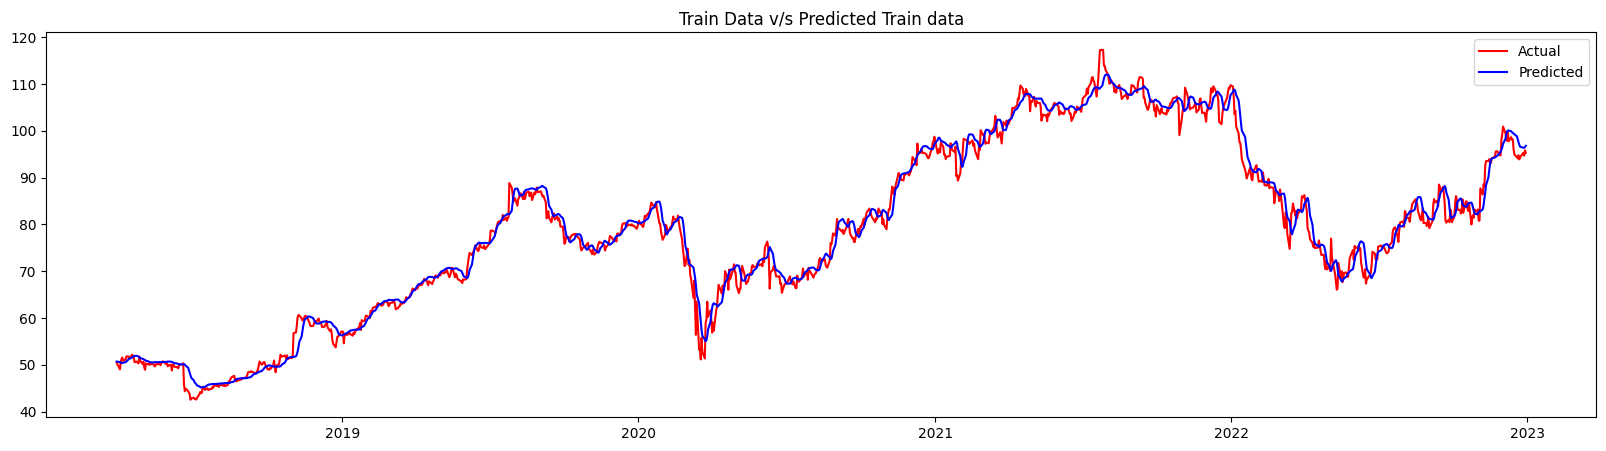

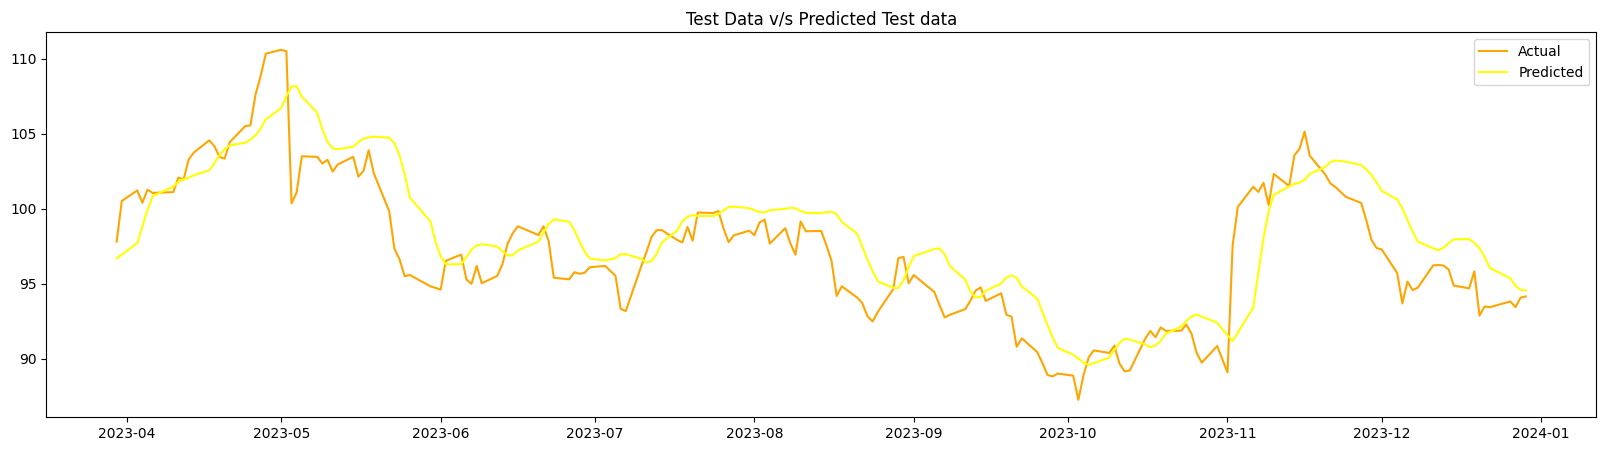

In [38]:
#LSTM
evaluate_models(lstm_model, "LSTM(Long Short Term Memory)", X_train_data, Y_train_data, X_test_data, Y_test_data)

###GRU

In [39]:
gru_model = Sequential()
gru_model.add(GRU(units = 50, return_sequences = True, input_shape = (X_train_data.shape[1], 1)))
gru_model.add(GRU(units = 50, return_sequences = True))
gru_model.add(GRU(units = 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
gru_model.compile(loss = "mean_squared_error", optimizer = "adam")

In [41]:
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 60, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 60, 50)              │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 1)                   │             159 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,409 (91.44 KB)

 Trainable params: 23,409 (91.44 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
gru_model.fit(X_train_data, Y_train_data, validation_data = (X_test_data, Y_test_data), epochs = 60, batch_size = 50, verbose = 1)

Epoch 1/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 0.1168 - val_loss: 0.0088
Epoch 2/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.0096 - val_loss: 0.0025
Epoch 3/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 4/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 5/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 6/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 7/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 8/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 9/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 10/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 11/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 12/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - los

========================= GRU(Gated Recurrent Unit) =========================
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(1199, 1) (1199,) (1199, 60, 1)
(190, 1) (190,) (190, 60, 1)
Mean Absolute Errors is :
 		 trained data:  1.13430650598114 
 		 test data:  1.1975540161132807
--------------------------------------------------
Root Mean squared Error is :
 		 trained data:  1.6293158932882985 
 		 test data:  1.702168566527355
--------------------------------------------------
R-Squared score is :
 		 trained data:  0.9919308670024146 
 		 test data:  0.8552269759827453


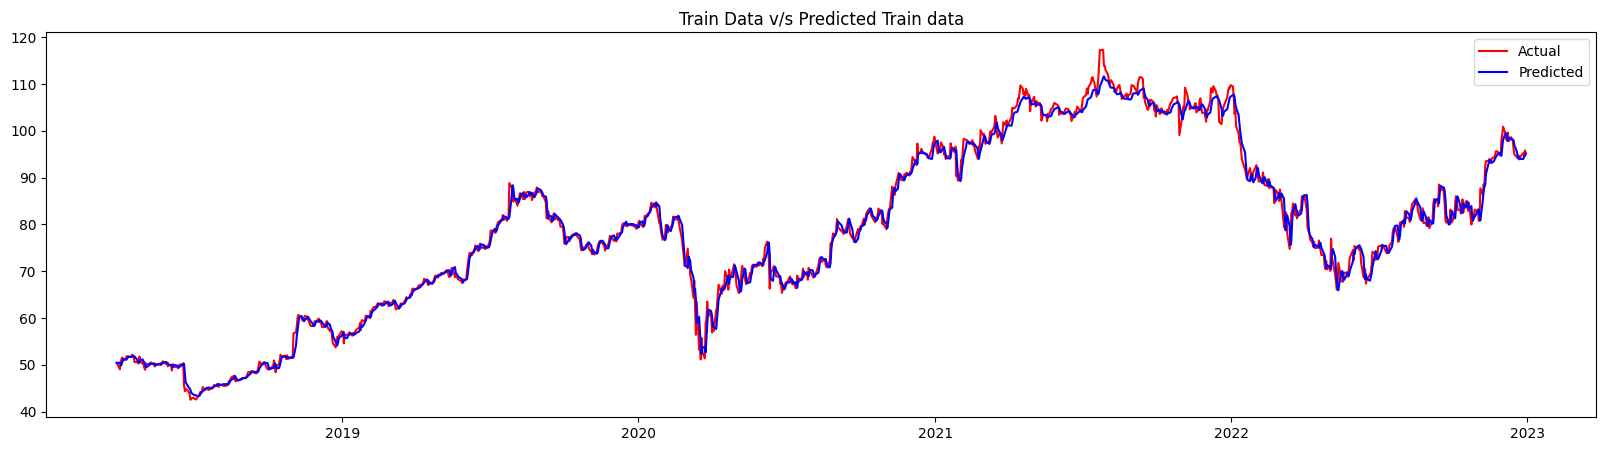

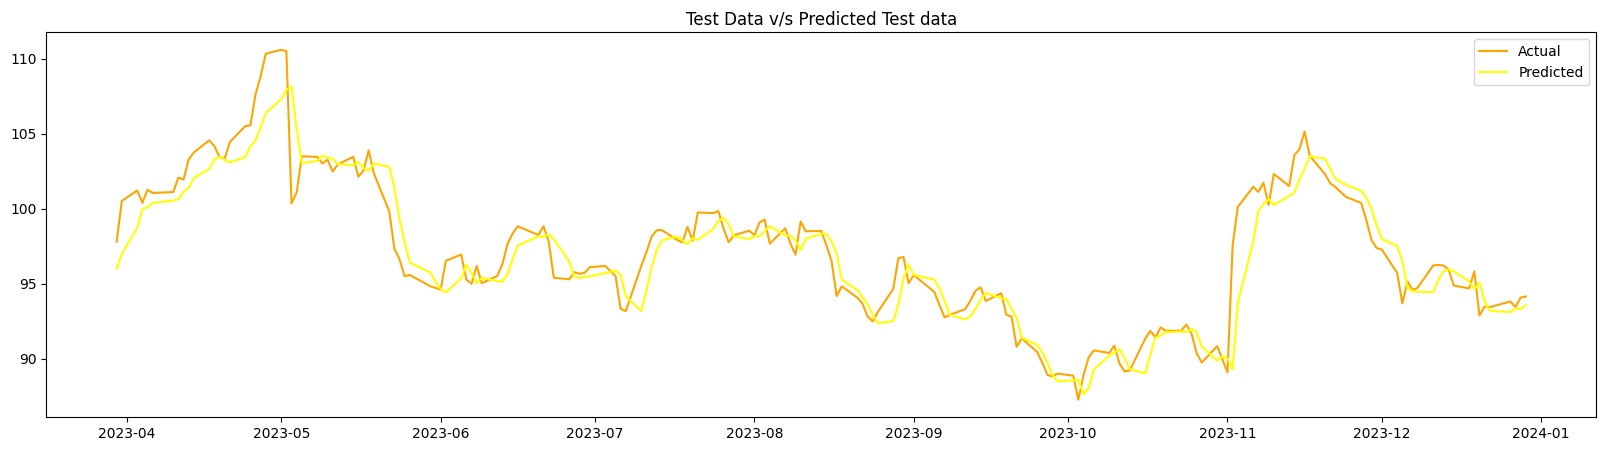

In [43]:
evaluate_models(gru_model, "GRU(Gated Recurrent Unit)", X_train_data, Y_train_data, X_test_data, Y_test_data)

###Hybrid Model(LSTM + Dense Layer)

In [44]:
X_train_data.shape

(1199, 60, 1)

In [45]:
hybrid_model = Sequential()
hybrid_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_data.shape[1], 1)))
hybrid_model.add(LSTM(units = 50, return_sequences = True))
hybrid_model.add(LSTM(units = 50, return_sequences = True))

hybrid_model.add(Dense(units=25, activation='relu'))
hybrid_model.add(Dense(units=10, activation='relu'))
hybrid_model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
hybrid_model.compile(loss = "mean_squared_error", optimizer = "adam")

In [47]:
hybrid_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 60, 25)              │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 60, 10)              │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 60, 1)               │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,346 (204.48 KB)

 Trainable params: 52,346 (204.48 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
hybrid_model.fit(X_train_data, Y_train_data, validation_data = (X_test_data, Y_test_data), epochs = 60, batch_size = 50, verbose = 1)

Epoch 1/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - loss: 0.2165 - val_loss: 0.0632
Epoch 2/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0816 - val_loss: 0.1237
Epoch 3/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0686 - val_loss: 0.0532
Epoch 4/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0663 - val_loss: 0.0762
Epoch 5/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 0.0647 - val_loss: 0.0568
Epoch 6/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0623 - val_loss: 0.0813
Epoch 7/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0634 - val_loss: 0.0578
Epoch 8/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0650 - val_loss: 0.0650
Epoch 9/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0619 - val_loss: 0.0799
Epoch 10/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.0628 - val_loss: 0.0771
Epoch 11/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0600 - val_loss: 0.0763
Epoch 12/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss:

In [49]:
print(X_train_data.shape, X_test_data.shape, Y_train_data.shape, Y_test_data.shape)

(1199, 60, 1) (190, 60, 1) (1199,) (190,)


========================= Hybrid Model =========================
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
(1199,) (1199,) (1199, 60, 1)
(190,) (190,) (190, 60, 1)
Mean Absolute Errors is :
 		 trained data:  14.632815770649533 
 		 test data:  18.792506248072574
--------------------------------------------------
Root Mean squared Error is :
 		 trained data:  17.918524404020705 
 		 test data:  19.37890572468024
--------------------------------------------------
R-Squared score is :
 		 trained data:  -879.6783807160343 
 		 test data:  -14096.21180871852


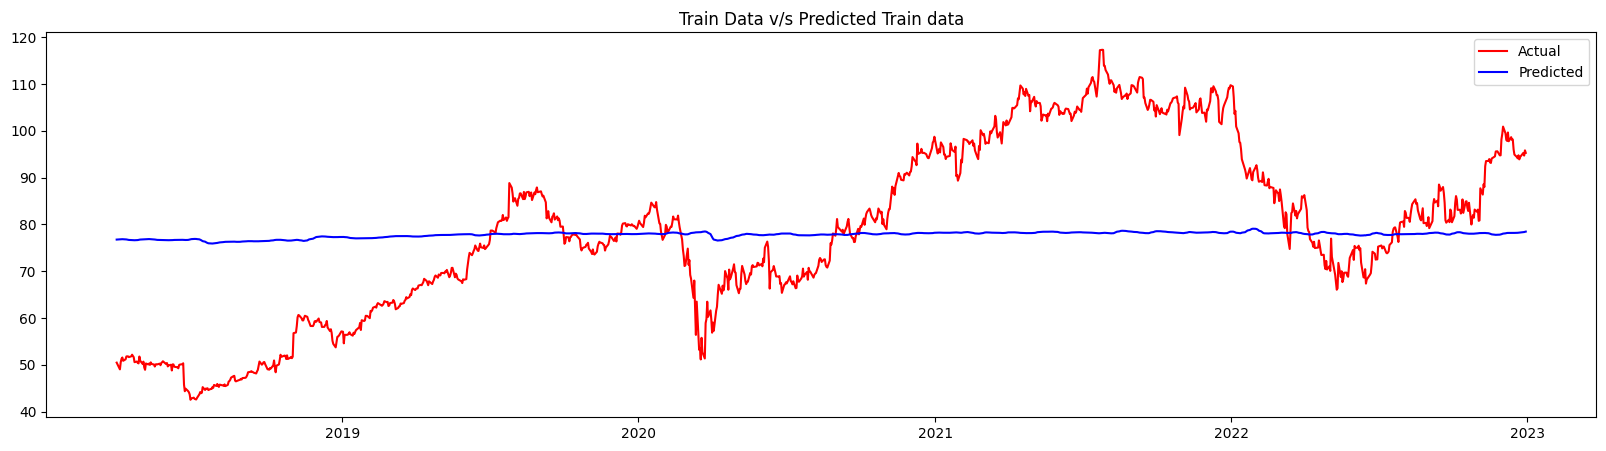

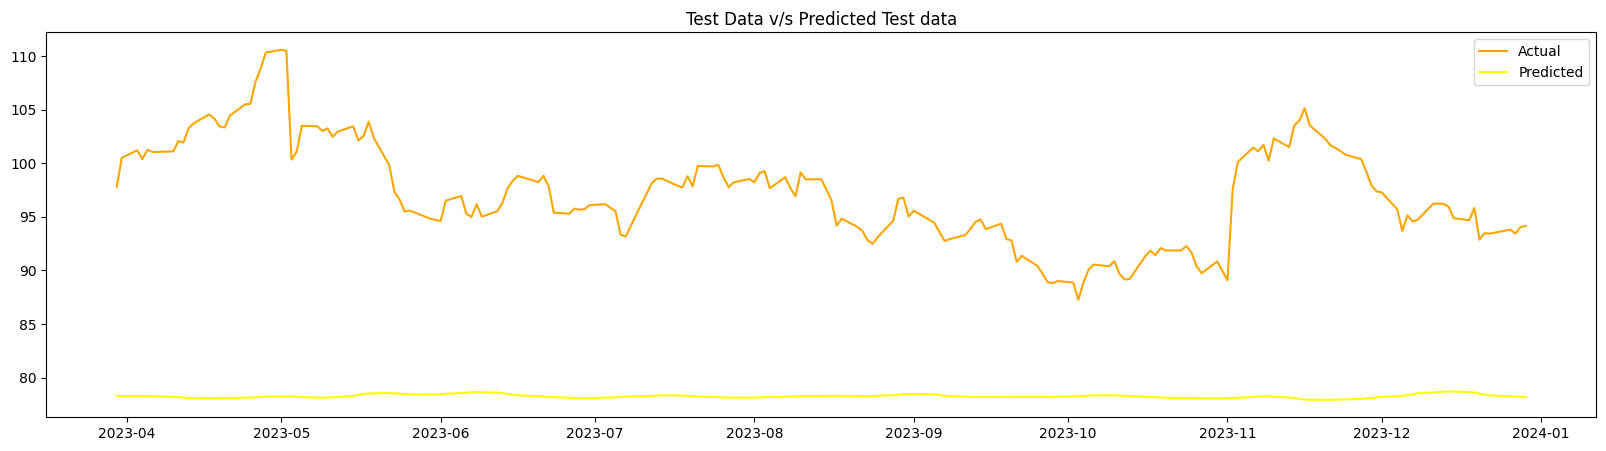

In [50]:
evaluate_models(hybrid_model, "Hybrid Model", X_train_data, Y_train_data, X_test_data, Y_test_data)

###Attention Model

##Forecasting

In [51]:
for mdl in eval.keys():
  print("-"*25,mdl,"-"*25)
  df = pd.DataFrame(eval[mdl])
  print(df)

------------------------- LSTM(Long Short Term Memory) -------------------------
            Mean Absolute Error  Root Mean Squared Error  R-Squared Score
train data             1.645384                 2.302790          0.98431
test data              2.204849                 2.799256          0.57443
------------------------- GRU(Gated Recurrent Unit) -------------------------
            Mean Absolute Error  Root Mean Squared Error  R-Squared Score
train data             1.134307                 1.629316         0.991931
test data              1.197554                 1.702169         0.855227
------------------------- Hybrid Model -------------------------
            Mean Absolute Error  Root Mean Squared Error  R-Squared Score
train data            14.632816                17.918524      -879.678381
test data             18.792506                19.378906    -14096.211809


In [52]:
forecast_dates

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-08', '2024-01-09', '2024-01-10',
               '2024-01-11', '2024-01-12',
               ...
               '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20',
               '2024-12-23', '2024-12-24', '2024-12-26', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', length=248, freq=None)

In [53]:
Y_forecast_prev_data = Y_test_data[-no_of_days_to_analyse:]
Y_forecast_prev_data.shape

(60,)

In [54]:
def forecast_dataset(model, name, data, column_size, forecast_dates):
  y = []
  data = data.reshape(1, data.shape[0], 1)
  # print(model, data, column_size, forecast_dates)
  for i in range(len(forecast_dates)):
    new_value = model.predict(data[:, i:i + column_size, :])
    data = np.append(data, new_value.reshape(1, 1, new_value.shape[1]), axis=1)
    new_value = scaler.inverse_transform(new_value)
    y.append(new_value)
  return np.array(y)


def forecast(model, name, Y_forecast_data):
  Y_forecast_data.reshape(Y_forecast_data.shape[0])
  date_filtered = data[data.index >= '2024-01-01']

  plt.figure(figsize = (18,5))
  plt.plot(forecast_dates, Y_forecast_data.reshape(Y_forecast_data.shape[0], 1), color = "orange", label = "Actual")
  plt.plot(date_filtered.index, date_filtered["Close"], color = "yellow", label = "Predicted")
  plt.title(f"Actual Data v/s Predicted Test data for {name}")
  plt.legend()
  plt.show()
  print()


In [55]:
Y_lstm_forecast_data = forecast_dataset(lstm_model, "LSTM", Y_forecast_prev_data, no_of_days_to_analyse, forecast_dates)

Y_gru_forecast_data = forecast_dataset(gru_model, "GRU", Y_forecast_prev_data, no_of_days_to_analyse, forecast_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

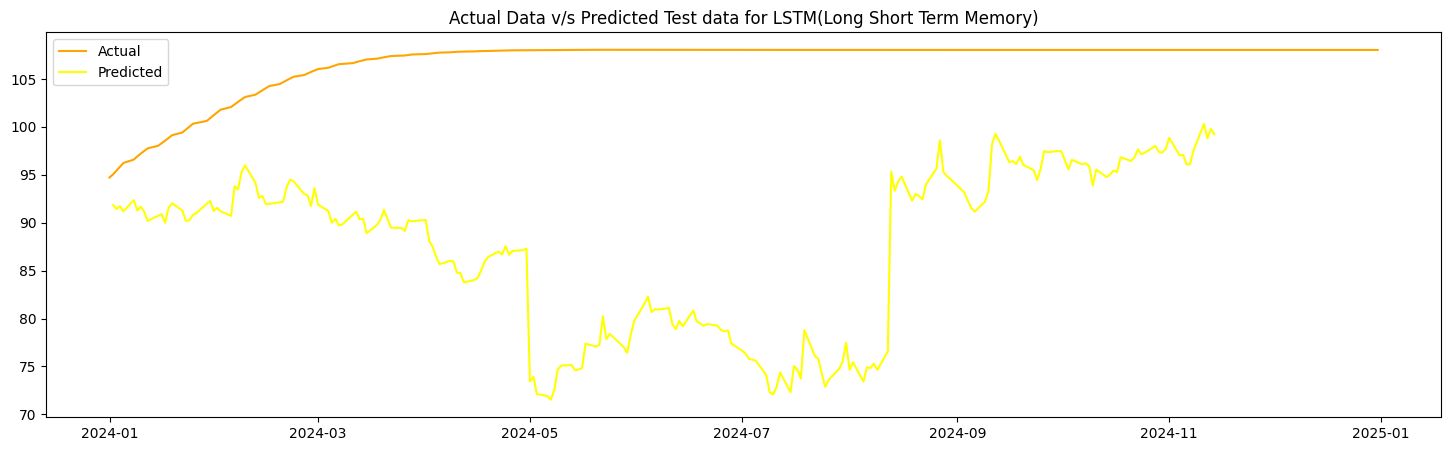

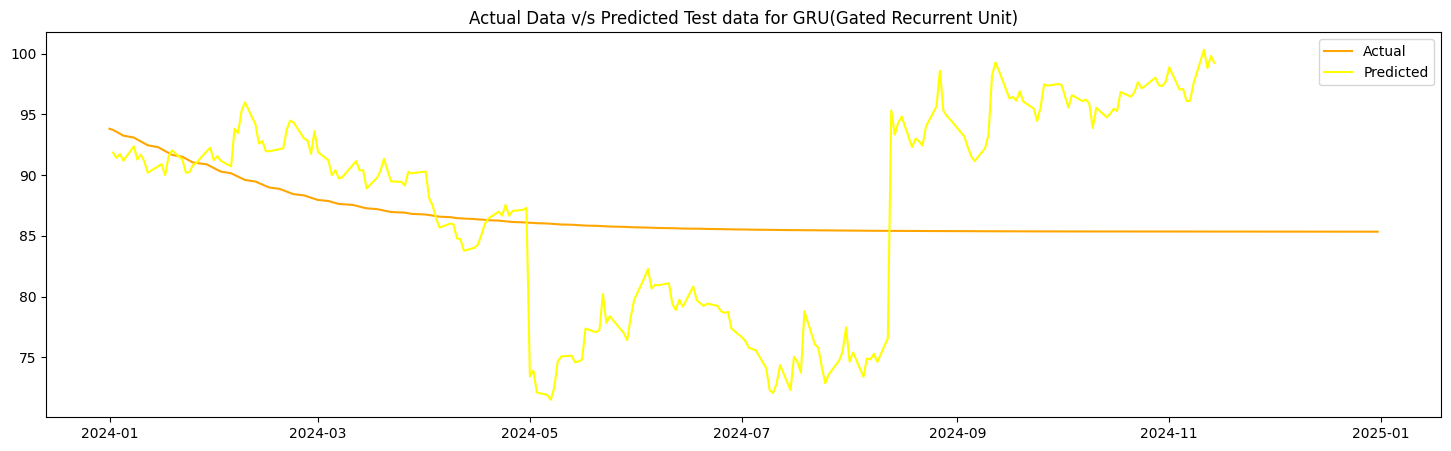

In [56]:
forecast(lstm_model, "LSTM(Long Short Term Memory)", Y_lstm_forecast_data)

forecast(gru_model, "GRU(Gated Recurrent Unit)", Y_gru_forecast_data)

# forecast(hybrid_model, "GRU(Gated Recurrent Unit)", Y_hybrid_forecast_data)

#Hyperparameter Tuning

In [ ]:
units = [20, 30, 40, 50, 60, 70, 80, 90]
learning_rate = [0.001, 0.003, 0.005, 0.007, 0.009, 0.01]
batch_size = [30, 50, 70, 90, 100]
epochs = [60, 80, 100, 120]
lstm_params_grid = {
    'batch_size': batch_size,
    'epochs': epochs
}

In [76]:
lstm_model_wrapped = KerasRegressor(model=lstm_model, metrics=['accuracy'], verbose=0)
lstm_model_grid = GridSearchCV(estimator=lstm_model_wrapped, param_grid=lstm_params_grid, cv=3, n_jobs=-1, scoring="accuracy")
lstm_model_grid

GridSearchCV(cv=3,
             estimator=KerasRegressor(metrics=['accuracy'], model=<Sequential name=sequential, built=True>, verbose=0),
             n_jobs=-1,
             param_grid={'batch_size': [30, 50, 70, 90, 100],
                         'epochs': [60, 80, 100, 120]},
             scoring='accuracy')

In [77]:
lstm_model_grid.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__model', 'estimator__build_fn', 'estimator__warm_start', 'estimator__random_state', 'estimator__optimizer', 'estimator__loss', 'estimator__metrics', 'estimator__batch_size', 'estimator__validation_batch_size', 'estimator__verbose', 'estimator__callbacks', 'estimator__validation_split', 'estimator__shuffle', 'estimator__run_eagerly', 'estimator__epochs', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [ ]:
lstm_model_grid.fit(X_train_data, Y_train_data)

In [ ]:
lstm_randomized_search = RandomizedSearchCV(estimator=lstm_model_wrapped, param_distributions=lstm_params_grid, cv=3, n_iter=10, n_jobs=-1)
lstm_randomized_search